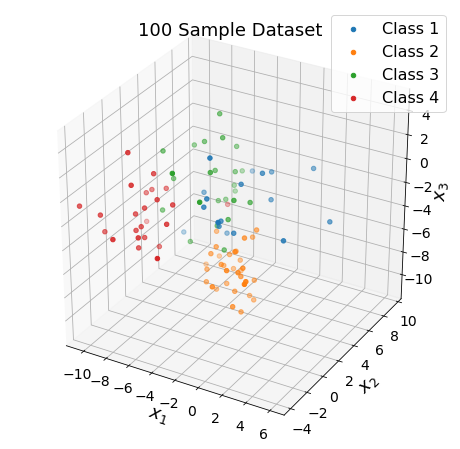

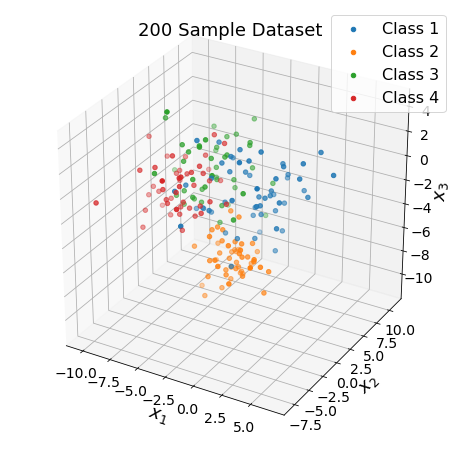

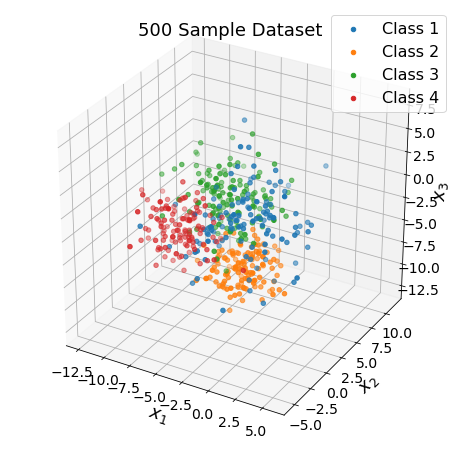

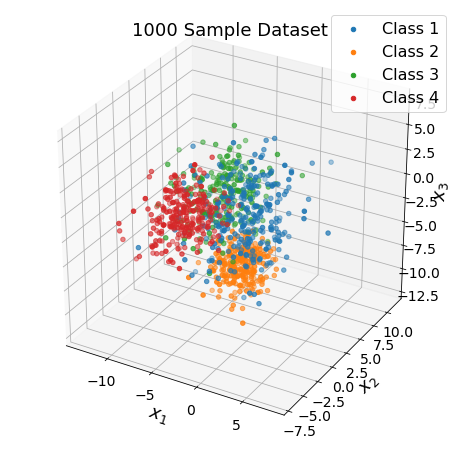

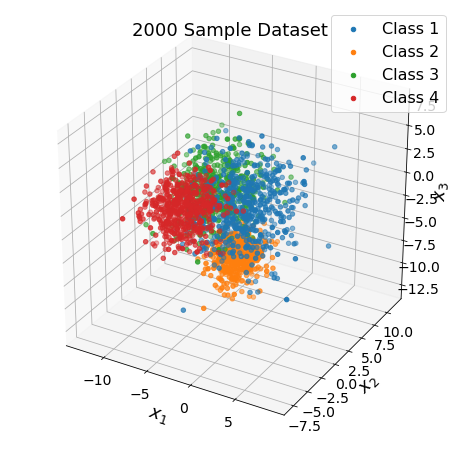

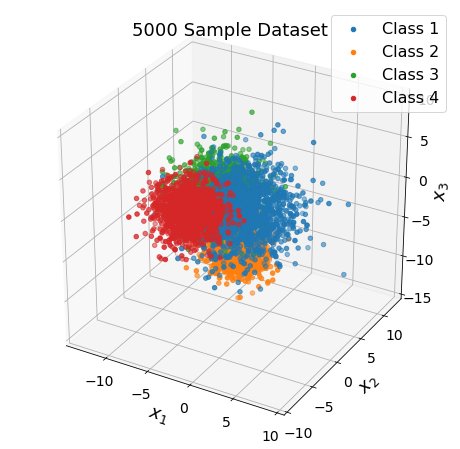

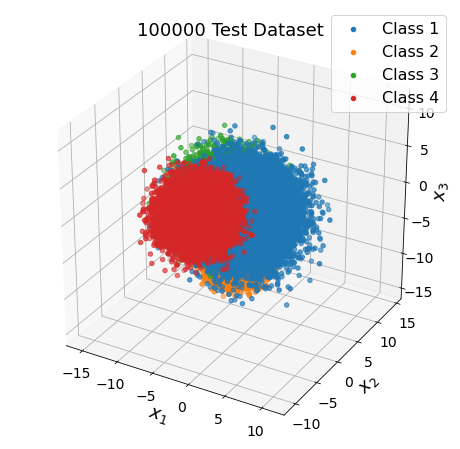

Confusion Matrix (rows: Predicted class, columns: True class):
[[22520     1   468  1025]
 [   28 21874   588  3999]
 [  631   345 22225  1359]
 [ 1611  2888  1621 18817]]
Total Number of Misclassified Samples: 14564
Empirically Estimated Probability of Error: 0.1456



In [1]:
import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors as mcol

import numpy as np

from scipy.stats import multivariate_normal as mvn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold # Important new include

import torch
import torch.nn as nn
import torch.nn.functional as F
# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)
torch.manual_seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

"""
C = 4 Classes with uniform priors
3D real valued random vector x (pick your own mean and covariance for each class)
Adjust params so MAP classifier that uses true data PDF achieves 10-20% prob(error)
"""

def gmm_params():
    xm = -3.2
    ym = 1.9
    zm = -2.7
    params = {}
    params['mu'] = np.array([ [xm*0, ym*0, zm*0],
                    [xm*1, ym*2, zm*3],
                    [xm*2, ym*3, zm*1],
                    [xm*1, ym*1, zm*2]])
    params['cov'] = np.array([[[7, 0, 0],
                    [0, 7, 0],
                    [0, 0, 7]],
                    
                    [[2, 0, 0],
                    [0, 2, 0],
                    [0, 0, 2]],

                    [[5, 0, 0],
                    [0, 5, 0],
                    [0, 0, 5]],

                    [[3, 0, 0],
                    [0, 3, 0],
                    [0, 0, 3]]
                    ])
    params['priors'] = np.array([0.25, 0.25, 0.25, 0.25])
    return params

def genData(N):
    params = gmm_params()
    n = params['mu'].shape[1]
    # Class priors
    priors = np.array([0.25, 0.25, 0.25, 0.25])
    C = len(priors)

    u = np.random.rand(N)
    thresholds = np.cumsum(priors)
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes
    # print(f'Priors: {thresholds}')

    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N) # KEEP TRACK OF THIS


    # Plot for original data and their true labels
    L = np.array(range(1,C+1))
    # # Create data and plot it
    for l in L:
    #     # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
    #     # No. of samples in this component
        Nl = len(indices)  
        labels[indices] = l * np.ones(Nl)
        X[indices, :] =  mvn.rvs(params['mu'][l-1], params['cov'][l-1], Nl)
    return X, labels


class TwoLayerMLP(nn.Module):
    # Two-layer MLP (not really a perceptron activation function...) network class
    
    def __init__(self, input_dim, hidden_dim, C):
        super(TwoLayerMLP, self).__init__()
        # Fully connected layer WX + b mapping from input_dim (n) -> hidden_layer_dim
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        # Output layer again fully connected mapping from hidden_layer_dim -> outputs_dim (C)
        self.output_fc = nn.Linear(hidden_dim, C)
        # Log Softmax (faster and better than straight Softmax)
        # dim=1 refers to the dimension along which the softmax operation is computed
        # In this case computing probabilities across dim 1, i.e., along classes at output layer
        self.log_softmax = nn.LogSoftmax(dim=1) 
        
    # Don't call this function directly!! 
    # Simply pass input to model and forward(input) returns output, e.g. model(X)
    def forward(self, X):
        # X = [batch_size, input_dim (n)]
        X = self.input_fc(X)
        # Non-linear activation function, e.g. ReLU (default good choice)
        # Could also choose F.softplus(x) for smooth-ReLU, empirically worse than ReLU
        X = F.relu(X)
        # X = [batch_size, hidden_dim]
        # Connect to last layer and output 'logits'
        X = self.output_fc(X)
        # Squash logits to probabilities that sum up to 1
        y = self.log_softmax(X)
        return y

    

### MAIN ###

### GENERATE DATA ###


Ntrain = np.array([100,200,500,1000,2000,5000])
Ntest = 100000
X = [] 
labels = []
for i in range(len(Ntrain)):
    Xtemp, ltemp = genData(Ntrain[i])
    X.append(Xtemp)
    labels.append(ltemp)


# marker_shapes = 'd+.x'
marker_colors = 'rbgy' 
# fig = plt.figure()
C = 4
L = np.array(range(1,C+1))
for i in range(len(Ntrain)):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d',)
    for l in L:
        ax.scatter(X[i][labels[i]==l, 0], X[i][labels[i]==l, 1], X[i][labels[i]==l, 2],\
                   marker_colors[l-1], label='Class {}'.format(l))
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_zlabel(r"$x_3$")
    ax.legend()
    plt.title("{} Sample Dataset".format(Ntrain[i]))
    Nl = np.array([sum(labels[i] == l) for l in L])
    # print("Training set {:d}...".format(Ntrain[i]))
    # print("Number of samples from Class 1: {:d}".format(Nl[0]))
    # print("                       Class 2: {:d}".format(Nl[1]))
    # print("                       Class 3: {:d}".format(Nl[2]))
    # print("                       Class 4: {:d}".format(Nl[3]))
    # print()
    plt.show()


# ### Generate TEST DATA ###
Xtest, labelsTest = genData(Ntest)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d',)
for l in L:
    ax.scatter(Xtest[labelsTest==l, 0], Xtest[labelsTest==l, 1], Xtest[labelsTest==l, 2],\
               marker_colors[l-1], label='Class {}'.format(l))
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")
ax.legend()
plt.title("{} Test Dataset".format(Ntest))
Nl = np.array([sum(labelsTest == l) for l in L])
# print("Test set {:d}".format(Ntest))
# print("Number of samples from Class 1: {:d}".format(Nl[0]))
# print("                       Class 2: {:d}".format(Nl[1]))
# print("                       Class 3: {:d}".format(Nl[2]))
# print("                       Class 4: {:d}".format(Nl[3]))
# print()
plt.show()



### Now compute MAP with 10-20% accuracy ###


params = gmm_params()


# MAP for test dataset
class_cond_likelihoods = np.array([mvn.pdf(Xtest, params['mu'][c], params['cov'][c]) for c in range(C)])
class_priors = np.diag(params['priors'])
class_posteriors = class_priors.dot(class_cond_likelihoods)

# MAP rule, take largest class posterior per example as your decisions matrix (N, 1)
decisions = np.argmax(class_posteriors, axis=0) + np.ones(Ntest) 

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labelsTest)
print(conf_mat)
correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Number of Misclassified Samples: {:d}".format(Ntest - correct_class_samples))
prob_error_MAP = 1 - (correct_class_samples / Ntest)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error_MAP))
print()




In [2]:
def model_train(model, data, labels, criterion, optimizer, num_epochs=25):

    # Apparently good practice to set this "flag" too before training
    # Does things like make sure Dropout layers are active, gradients are updated, etc.
    # Probably not a big deal for our toy network, but still worth developing good practice
    model.train()
    # Optimize the neural network
    for epoch in range(num_epochs):
        # These outputs represent the model's predicted probabilities for each class. 
        outputs = model(data)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, labels)
        # Set gradient buffers to zero explicitly before backprop
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()
        
    return model

In [4]:
def model_predict(model, data, labels):
    # Similar idea to model.train(), set a flag to let network know your in "inference" mode
    model.eval()
    N = len(data)
#     print(N)
    # Disabling gradient calculation is useful for inference, only forward pass!!
    with torch.no_grad():
        # Evaluate nn on test data and compare to true labels
        predicted_labels = model(data)
        # Back to numpy
        predicted_labels = predicted_labels.detach().cpu().numpy()
        Z = np.argmax(predicted_labels, 1)
    
    conf_mat = confusion_matrix(Z, labels-1)
    correct_class_samples = np.sum(np.diag(conf_mat))
    prob_error = 1 - (correct_class_samples / N)
#     print(conf_mat)
#     print("Total Number of Misclassified Samples: {:d}".format(N - correct_class_samples))
#     print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))
#     print()
    return Z, prob_error

# Z, acc = model_predict(model,X_tensor[0],labels[0])
# print(acc)

In [5]:
def neuron_cross_validation(X,labels,X_tensor,l_tensor):#,Xtest,labelsTest):
    K = 10
    kf = KFold(n_splits=K, shuffle=True)
    start = 3
    neurons = np.arange(start, start+15, 1)
    n_hidden = len(neurons)
#     X_tensor_test = torch.FloatTensor(Xtest)
#     y_tensor_test = torch.LongTensor(labelsTest-1)
    
    # Store predictions per degree using ordered X samples for plotting best fit lines
#     y_train_preds_ordered = np.empty(n_degs, dtype=np.ndarray)
    # Allocate space for CV
    # No need for training loss storage too but useful comparison
    mse_valid_mk = np.empty((n_hidden, K)) 
    mse_train_mk = np.empty((n_hidden, K)) # Indexed by model m, data partition k
    acc = np.empty((n_hidden, K))
    accTest = np.empty(n_hidden)
    i = 0
    for n in neurons:  
        k = 0
        for train_indices, valid_indices in kf.split(X):
            # Extract the training and validation sets from the K-fold split
            X_train_k = X[train_indices]
            y_train_k = labels[train_indices]
            X_train_tensor = torch.FloatTensor(X_train_k)
            y_train_tensor = torch.LongTensor(y_train_k-1)
            
            X_valid_k = X[valid_indices]
            y_valid_k = labels[valid_indices]
            X_valid_tensor = torch.FloatTensor(X_valid_k)


            #Train it
            model = TwoLayerMLP(input_dim, n, output_dim)
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            criterion = nn.CrossEntropyLoss()
            num_epochs = 100
            model = model_train(model, X_train_tensor, y_train_tensor, criterion, optimizer, num_epochs=num_epochs)
            
            #Validate/predict it and record p(error)
            Z, acc[i,k] = model_predict(model,X_valid_tensor,y_valid_k)
#             Z, accTest[i,k] = model_predict(model,X_tensor_test,labelsTest)
            k += 1
        i+=1
    accuracy = np.mean(acc, axis=1)
    min_acc = np.min(accuracy)
    min_ind = np.argmin(accuracy)
    n_optimal = neurons[min_ind]
    
#     for i in range(len(neurons)):
#         min_accTest[i] = accTest[]

#     j = 0
#     models = []
#     for n in n_optimal:
#         model = TwoLayerMLP(input_dim, n, output_dim)
#         optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#         criterion = nn.CrossEntropyLoss()
#         num_epochs = 100
#         model = model_train(model, X_tensor, l_tensor, criterion, optimizer, num_epochs=num_epochs)
#         #Validate/predict it and record p(error)
#         Z, accTest[j] = model_predict(model,Xtest,labelsTest)
#         models.append(model)
#         j+=1
    return min_ind, min_acc, n_optimal, accuracy#, models, accTest

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# torch.cuda.device(device)
# return
input_dim = X[0].shape[1]
# n_hidden_neurons = 16   #VARY THIS FOR CV
output_dim = C

# It's called an MLP but really it's not...
# model = TwoLayerMLP(input_dim, n_hidden_neurons, output_dim)
# model.to(device)
# # Visualize network architecture
# print(model)
# summary(model, input_size=(16, input_dim))


# Convert numpy structures to PyTorch tensors, as these are the data types required by the library

X_tensor = []
l_tensor = []
for i in range(len(Ntrain)):
    X_tensor_temp = torch.FloatTensor(X[i])
    l_tensor_temp = torch.LongTensor(labels[i]-1)
#     X_tensor_temp = X_tensor_temp.to(device)
#     l_tensor_temp = l_tensor_temp.to(device) 
    X_tensor.append(X_tensor_temp) 
    l_tensor.append(l_tensor_temp)

cuda


100 Samples...
Best no. of neurons:             12
Probability of error (Training): 0.24

200 Samples...
Best no. of neurons:             13
Probability of error (Training): 0.205

500 Samples...
Best no. of neurons:             16
Probability of error (Training): 0.196

1000 Samples...
Best no. of neurons:             15
Probability of error (Training): 0.19499999999999998

2000 Samples...
Best no. of neurons:             14
Probability of error (Training): 0.193

5000 Samples...
Best no. of neurons:             17
Probability of error (Training): 0.20719999999999997



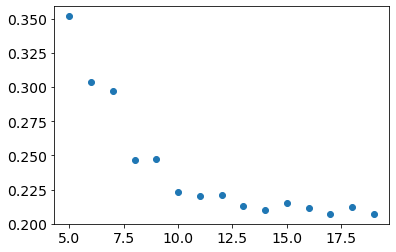

In [7]:
start = 5
neurons_test = np.arange(start, start+15, 1)
neurons = np.zeros(len(Ntrain))
prob_error = np.zeros(len(Ntrain))
for i in range(len(Ntrain)):
    min_ind, min_acc, nNeurons,acc = neuron_cross_validation(X[i],labels[i],X_tensor[i],l_tensor[i])
    neurons[i] = nNeurons
    prob_error[i] = min_acc
    print(Ntrain[i],"Samples...")
    print("Best no. of neurons:            ",nNeurons)
    print("Probability of error (Training):",min_acc)
    print()


plt.scatter(neurons_test,acc)
plt.show()

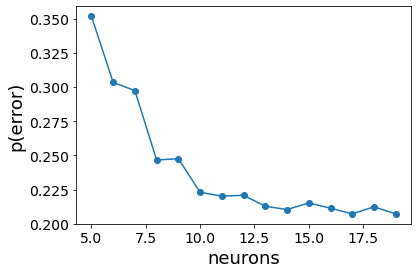

In [13]:
plt.plot(neurons_test,acc)
plt.scatter(neurons_test,acc)

plt.xlabel('neurons')
plt.ylabel('p(error)')
plt.show()

In [9]:
models = []
j = 0
neurons = neurons.astype(int)
X_tensor_test = torch.FloatTensor(Xtest)
l_tensor_test = torch.LongTensor(labelsTest-1)
accTest = np.zeros(len(neurons))

for n in neurons:
    model = TwoLayerMLP(input_dim, n, output_dim)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    num_epochs = 100
    model = model_train(model, X_tensor[j], l_tensor[j], criterion, optimizer, num_epochs=num_epochs)
    #Validate/predict it and record p(error)
    Z, accTest[j] = model_predict(model,X_tensor_test,labelsTest)
    models.append(model)
    print(Ntrain[j],"Samples Trained evaluated on 100000 Sample Test...")
    print("Best no. of neurons:            ",n)
    print("Probability of error (Test):",accTest[j])
    print()
    j+=1
    
# print(accTest)
# print(models)

100 Samples Trained evaluated on 100000 Sample Test...
Best no. of neurons:             12
Probability of error (Test): 0.24431000000000003

200 Samples Trained evaluated on 100000 Sample Test...
Best no. of neurons:             13
Probability of error (Test): 0.20889000000000002

500 Samples Trained evaluated on 100000 Sample Test...
Best no. of neurons:             16
Probability of error (Test): 0.20604

1000 Samples Trained evaluated on 100000 Sample Test...
Best no. of neurons:             15
Probability of error (Test): 0.20252000000000003

2000 Samples Trained evaluated on 100000 Sample Test...
Best no. of neurons:             14
Probability of error (Test): 0.17979

5000 Samples Trained evaluated on 100000 Sample Test...
Best no. of neurons:             17
Probability of error (Test): 0.19428999999999996



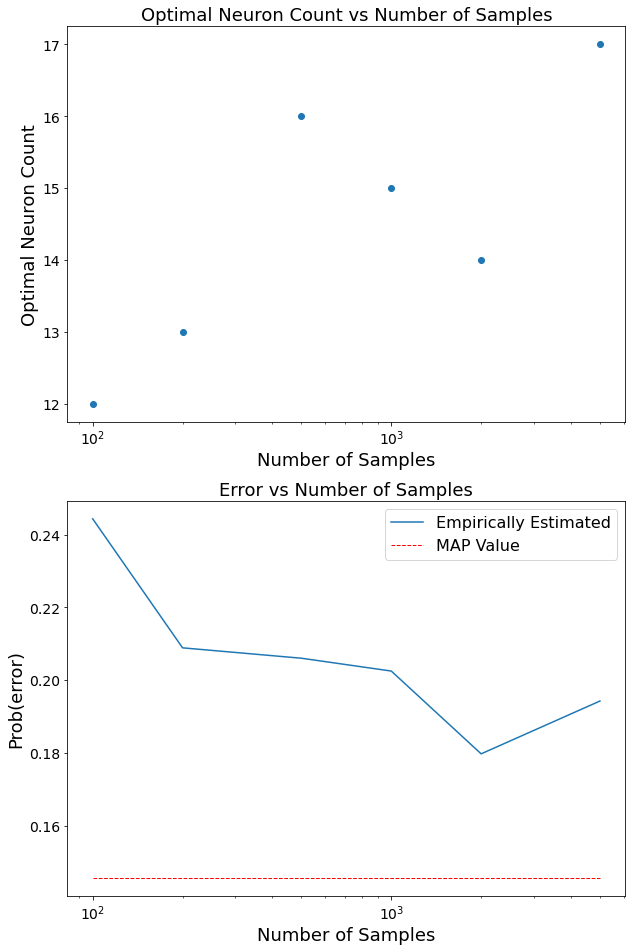

In [11]:
line = np.ones(len(Ntrain))*prob_error_MAP
fig_plot, ax_plot = plt.subplots(2, 1, figsize=(10, 16));
ax_plot[0].scatter(Ntrain, neurons)
ax_plot[0].set_xscale('log')
ax_plot[0].set_xlabel('Number of Samples')
ax_plot[0].set_ylabel('Optimal Neuron Count')
ax_plot[0].set_title('Optimal Neuron Count vs Number of Samples')

ax_plot[1].plot(Ntrain, accTest, label='Empirically Estimated')
ax_plot[1].plot(Ntrain, line, color='red', linestyle='dashed',lw = 1, label = 'MAP Value')
ax_plot[1].set_xscale('log')
ax_plot[1].set_xlabel("Number of Samples")
ax_plot[1].set_ylabel("Prob(error)")
ax_plot[1].legend()
ax_plot[1].set_title('Error vs Number of Samples')
plt.show()

In [ ]:
line = np.ones(len(Ntrain))*prob_error_MAP
plt.scatter(Ntrain, neurons)
plt.xscale('log')
plt.xlabel('# of Samples')
plt.ylabel('Optimal # of Neurons')

plt.show()

plt.plot(Ntrain, accTest, label='Empirically Estimated')
plt.plot(Ntrain, line, color='red', linestyle='dashed',lw = 1, label = 'Theoretical Value')
plt.legend(loc = 'best')
plt.xscale('log')
plt.xlabel('# of Samples')
plt.ylabel('Prob(error)')

plt.show()